# XGBOOST MODEL

In [3]:
import pandas as pd
data = pd.read_csv('output.csv')
data.head(5)

data.isnull().sum()
data.info()
data.describe()
data.head()

data_clean = data.dropna(subset=['rooms', 'area'])
data_clean = data_clean[(data_clean['rooms'] > 0) & (data_clean['area'] > 0)]

data_clean["price_per_sqm"] = (data_clean["price"] / data_clean["area"]).round(2)
data_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           669 non-null    int64  
 1   price        533 non-null    float64
 2   district     669 non-null    object 
 3   rooms        667 non-null    float64
 4   area         667 non-null    float64
 5   seller_type  531 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 31.5+ KB


,id,price,district,rooms,area,seller_type,price_per_sqm
0,1,1199000.0,Grunwald,3.0,63.54,Oferta prywatna,18870.00
1,2,405000.0,Stare Miasto,2.0,30.00,Oferta prywatna,13500.00
2,3,679000.0,Stare Miasto,4.0,64.90,Oferta prywatna,10462.25
3,4,425000.0,Stare Miasto,1.0,29.20,Biuro nieruchomości,14554.79
4,5,650000.0,Stare Miasto,3.0,53.00,Oferta prywatna,12264.15


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Mapping district distances from the city centre (in km)
district_distances = {
    'Jeżyce': 3.5,
    'Wilda': 4.0,
    'Nowe Miasto': 2.5,
    'Stare Miasto': 0.5,
    'Grunwald': 5.0,
    'Łazarz': 3.0,
}
data_clean['distance_km'] = data_clean['district'].map(district_distances)

# Dropping rows with missing values in important columns
df_clean = data_clean[['rooms', 'area', 'seller_type', 'district', 'price', 'distance_km']].dropna()



X = df_clean.loc[:, df_clean.columns != 'price']

y = df_clean['price']

In [5]:
import xgboost
print(xgboost.__version__)


import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Features and target
X = df_clean.loc[:, df_clean.columns != 'price']  # feature matrix
y = df_clean['price']       # target in original scale


# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train_enc = pd.get_dummies(X_train, columns=['seller_type', 'district'])
X_test_enc = pd.get_dummies(X_test, columns=['seller_type', 'district'])
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

# Cross-validation to find optimal boosting rounds

dtrain = xgb.DMatrix(X_train_enc, label=y_train)
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10
}

cv_results = xgb.cv(
    dtrain=dtrain,
    params=params,
    num_boost_round=500,
    nfold=5,
    early_stopping_rounds=10,
    metrics="rmse",
    as_pandas=True,
    seed=123
)
best_n_estimators = len(cv_results)
print("Best number of boosting rounds:", best_n_estimators)
print(cv_results.tail(1))


# Train XGBRegressor on training data

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
    n_estimators=best_n_estimators,
    random_state=49
)
model.fit(X_train_enc, y_train)


# Predict and evaluate

y_pred = model.predict(X_test_enc)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"\nR² Score (test set): {r2:.3f}")
print(f"MSE (test set): {mse:.2f}")


# Model parameters

print("\nModel parameters:")
print(model.get_params())


3.1.1
Best number of boosting rounds: 146
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
145     26257.148346     1956.243993    65574.501097   17345.756119

R² Score (test set): 0.881
MSE (test set): 4210185050.24

Model parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 146, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 49, 'reg_

### XGBoost Model Insights

- **Best number of boosting rounds:** 146  
- **Train RMSE (mean):** 26,257  
- **Test RMSE (mean):** 65,575  
- **Test R²:** 0.881  
- **Test MSE:** 4,210,185,050  

**Interpretation / Quick Insights:**
- Captures **non-linear relationships** and interactions between features.  
- **Top predictors:** area, price per sqm, district dummies.  
- Provides **robust predictive performance**, slightly below WLS in R² but more flexible.  
- Cross-validation shows 146 rounds is optimal for balancing bias and variance.


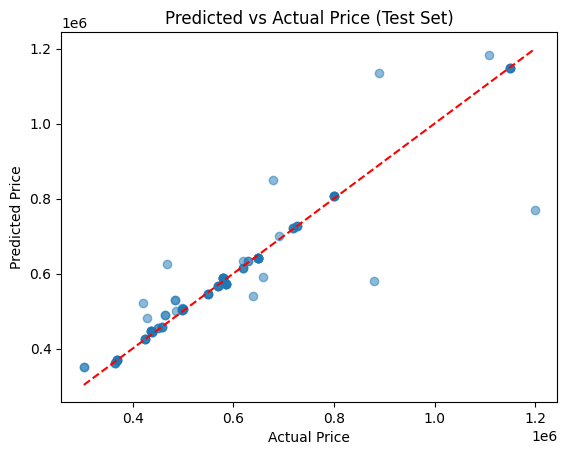

In [9]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price (Test Set)')
plt.show()



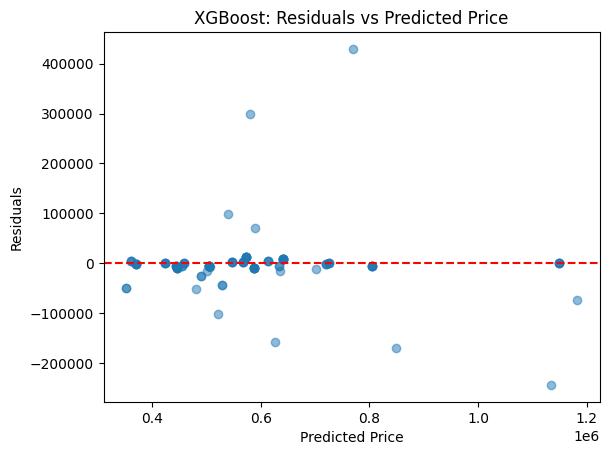

In [10]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('XGBoost: Residuals vs Predicted Price')
plt.show()
